In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This notebook contains code to reproduce the following from Mitra, et al.:

**Main Figures:** 
* Figure 3A: Overall mutation burden cases vs. ctrls
* Figure 3B: Size in cases vs. controls
* Figure 3C: mutation burden by category
* Figure 3D: Size diff by category

**Supplementary Figures:** 
* Supplementary Figure 10: OR as function of afreq/het and by male/female
* Supplementary Figure 11: QQ plots for TDT/assoc/fisher
* Supplementary Figure 12: power analysis

In [176]:
# Input per-locus info

#LOCFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.locus_stats.tab" # old

# Newer locfile with outlier families removed
LOCFILE = "/storage/mgymrek/ssc-denovos/denovos_GW_priors_Jan20/SSC_allphases_011720_denovos_GW_priors_Jul20.locus_stats_rmoutlierfams.tab"

# when done running to remove outlier families

# Input mutation results
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"
NAIVEMUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_011720_denovos_naive_Jan20.final_qc_mutations.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import statsmodels.api as sm

# Color keys
colors = ['gray','red','gold','blue','green','purple','brown','salmon','magenta','cyan','darkblue']

# Other data paths
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation-rmdup.bed"
AFREQFILE = "/storage/mgymrek/ssc-denovos/allele-freqs-revision/SSC_merged_allele_counts.tab"
HETFILE = "/storage/mgymrek/ssc-denovos/allele-freqs-revision/SSC_merged_het.tab"
AGEFILE = "/storage/ileena/denovos4/metadata/ssc_4phases_ages.csv"
SFARIFILE = "/storage/mgymrek/ssc-denovos/annotations/SFARI-Gene_genes_08-29-2019release_09-11-2019export.csv"
JACKGENES = "/storage/mgymrek/ssc-denovos/annotations/jack_102genes.txt"
CONSTRAINTFILE="/storage/mgymrek/ssc-denovos/mutea/MUTEA_Constraint_hg38_GangSTR.bed"

# Output path info
OUTDIR = "pdfs/"

In [177]:
# Load expansions
ndata = pd.read_csv(NAIVEMUTFILE, sep="\t")
ndata = ndata[(ndata["posterior"]==-1) & (ndata["mutsize"]>=5)] # moderately big expansion events

# Filter ones that occur too many times
expcounts = ndata.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata = pd.merge(ndata, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")
usefams = set(alldata["family"])

# Concatenate expansions
ndata = ndata[ndata.family.isin(usefams)]
alldata = pd.concat([alldata, ndata])

# Load sfari genes
sfari_genes = set(pd.read_csv(SFARIFILE)["gene-symbol"])
jack_genes = set([item.strip() for item in open(JACKGENES, "r").readlines()])

# Manually remove problematic families. TODO add this instead to the QC script
# 14151 proband had 130 mutations
# other families have <20 in both proband and sibling
rmfams = [14151, 12434, 12281, 13673, 13351, 13355, 13143]
alldata = alldata[~alldata.family.isin(rmfams)]

# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
alldata["chrom"] = alldata["chrom"].apply(GetChrom)
annot = annot[annot["chrom"].apply(lambda x: x not in ["X","chrX","Y","chrY"])]
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(alldata, annot, on=["chrom","pos"])

# Get age info
ages = pd.read_csv(AGEFILE)
ages["family"] = ages["fam_id"]
ages["child"] = ages["sample_id"]
ages["phenotype"] = ages["ssc_id"].apply(lambda x: [1,2]["p1" in x])
ages = ages[~np.isnan(ages["father_age_birth"])]

In [175]:
# Get Allele freq info
het = pd.read_csv(HETFILE, sep="\t")
het["chrom"] = het["chrom"].apply(GetChrom)

afreq = pd.read_csv(AFREQFILE, sep="\t")
afreq.columns = ["chrom","pos","newallele","count"]
afreq["chrom"] = afreq["chrom"].apply(GetChrom)
afreq = pd.merge(afreq, het[["chrom","pos","total"]], on=["chrom","pos"])
afreq["freq"] = afreq.apply(lambda x: float(x["count"])/x["total"], 1)

fdata = pd.merge(adata, afreq, on=["chrom","pos","newallele"], how="left")
fdata.ix[np.isnan(fdata["freq"]),"freq"] = 0
fdata.ix[np.isnan(fdata["count"]),"count"] = 0
fdata = fdata.drop("total", 1)
fdata = pd.merge(fdata, het[["chrom","pos","het","total"]], on=["chrom","pos"])

finaldata = pd.merge(fdata, ages[["family","child","sex","father_age_birth_years"]], on=["family","child"], how="left")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [140]:
AFF_COLOR = "red"
UNAFF_COLOR = "blue"

def GetCounts(df, pt, families, sex=None):
    famcounts = {}
    counts = df[df["phenotype"]==pt]
    if sex is not None:
        counts = counts[counts["sex"]==sex]
    for i in range(counts.shape[0]):
        fam = counts["family"].values[i]
        count = counts["nummut"].values[i]
        famcounts[fam] = count
    mutcounts = [famcounts.get(family, 0) for family in families]
    return mutcounts

def PlotBurden(full_fdata, fdata_list, fdata_list_labels, maxORy=None, col=None, freq=1, figprefix=None, adjust_patage=False):
    fdata = full_fdata
    
    # Get list of families to use
    families = set(fdata["family"])
    aff_female_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]=="female")]["family"])
    unaff_female_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]=="female")]["family"])
    aff_male_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]=="male")]["family"])
    unaff_male_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]=="male")]["family"])

    pt_counts_list_unaff = []
    pt_stderrs_list_unaff = []
    pt_counts_list_aff = []
    pt_stderrs_list_aff = []
    male_counts_list_unaff = []
    male_counts_list_aff = []
    female_counts_list_unaff = []
    female_counts_list_aff = []

    perc_mut_aff_all_list = []
    perc_mut_aff_female_list = []
    perc_mut_aff_male_list = []
    total_mut_all_list = []
    total_mut_female_list = []
    total_mut_male_list = []
    
    sizes_means_list_unaff = []
    sizes_stderrs_list_unaff = []
    sizes_means_list_aff = []
    sizes_stderrs_list_aff = []
    female_sizes_means_list_unaff = []
    female_sizes_means_list_aff = []
    male_sizes_means_list_unaff = []
    male_sizes_means_list_aff = []
    
    for i in range(len(fdata_list)):
        fdata = fdata_list[i]
        flabel = fdata_list_labels[i]
        usedata = fdata[(fdata["freq"]<=freq)]
        if col is not None:
            usedata = usedata[(usedata[col]>0)]
        print("num total muts=%s"%usedata.shape[0])
        print("num total control muts=%s male=%s female=%s"%(usedata[usedata["phenotype"]==1].shape[0],
                                                            usedata[(usedata["sex"]=="male") & (usedata["phenotype"]==1)].shape[0],
                                                            usedata[(usedata["sex"]=="female") & (usedata["phenotype"]==1)].shape[0]))
        print("num total case muts=%s male=%s female=%s"%(usedata[usedata["phenotype"]==2].shape[0],
                                                            usedata[(usedata["sex"]=="male") & (usedata["phenotype"]==2)].shape[0],
                                                            usedata[(usedata["sex"]=="female") & (usedata["phenotype"]==2)].shape[0]))
        child_counts = usedata.groupby(["child","phenotype","family","father_age_birth_years"], as_index=False).agg({"posterior": len})
        child_counts.columns = ["child","phenotype","family","father_age_birth_years","nummut"]
        child_counts_by_sex = usedata.groupby(["child","phenotype","family","sex"], as_index=False).agg({"posterior": len})
        child_counts_by_sex.columns = ["child","phenotype","family","sex","nummut"]

        aff_counts = GetCounts(child_counts, 2, families)
        unaff_counts = GetCounts(child_counts, 1, families)
        aff_male_counts = GetCounts(child_counts_by_sex, 2, aff_male_families, sex="male")
        aff_female_counts = GetCounts(child_counts_by_sex, 2, aff_female_families, sex="female")
        unaff_male_counts = GetCounts(child_counts_by_sex, 1, unaff_male_families, sex="male")
        unaff_female_counts = GetCounts(child_counts_by_sex, 1, unaff_female_families, sex="female")
    
        pt_counts = np.array([np.mean(unaff_counts), np.mean(aff_counts)])
        pt_stderrs = np.array([np.sqrt(np.var(unaff_counts)/len(families)), np.sqrt(np.var(aff_counts)/len(families))])
    
        # Update data lists
        pt_counts_list_unaff.append(np.mean(unaff_counts))
        pt_counts_list_aff.append(np.mean(aff_counts))
        pt_stderrs_list_unaff.append(np.sqrt(np.var(unaff_counts)/len(families)))
        pt_stderrs_list_aff.append(np.sqrt(np.var(aff_counts)/len(families)))
        male_counts_list_unaff.append(np.mean(unaff_male_counts))
        male_counts_list_aff.append(np.mean(aff_male_counts))
        female_counts_list_unaff.append(np.mean(unaff_female_counts))
        female_counts_list_aff.append(np.mean(aff_female_counts))
        
        # P-values
        print("***Test burden - %s"%flabel)
        print(len(unaff_counts))
        print("Unaff mean=%s"%np.mean(unaff_counts))
        print("Aff mean=%s"%np.mean(aff_counts))
        print("Mean diff=%s"%(np.mean(aff_counts)-np.mean(unaff_counts)))
        try:
            print(scipy.stats.mannwhitneyu(unaff_counts, aff_counts,  alternative="less"))
            print(scipy.stats.ttest_rel(unaff_counts, aff_counts))
        except: pass
        try:
            print("Male burden: %s"%str(scipy.stats.mannwhitneyu(unaff_male_counts, aff_male_counts, alternative="less")))
            print("Male burden: %s"%str(scipy.stats.ks_2samp(unaff_male_counts, aff_male_counts, alternative="greater")))
        except: pass
        try:
            print("Female burden: %s"%str(scipy.stats.mannwhitneyu(unaff_female_counts, aff_female_counts,  alternative="less")))
            print("Female burden: %s"%str(scipy.stats.ks_2samp(unaff_female_counts, aff_female_counts,  alternative="greater")))
        except: pass
        # odds ratios
        print("***Odds ratios")
        or_all = np.mean(aff_counts)/np.mean(unaff_counts)
        or_male = np.mean(aff_male_counts)/np.mean(unaff_male_counts)
        or_female = np.mean(aff_female_counts)/np.mean(unaff_female_counts)
        print("all=%s"%or_all)
        print("male=%s"%or_male)
        print("female=%s"%or_female)
        print("num proband all=%s"%len(aff_counts))
        print("num proband male=%s"%len(aff_male_counts))
        print("num proband female=%s"%len(aff_female_counts))
        print("num unaff all=%s"%len(unaff_counts))
        print("num unaff male=%s"%len(unaff_male_counts))
        print("num unaff female=%s"%len(unaff_female_counts))
        
        total_mut_all_list.append(np.sum(aff_counts)+np.sum(unaff_counts))
        perc_mut_aff_all_list.append(np.sum(aff_counts)/(np.sum(aff_counts)+np.sum(unaff_counts)))
        total_mut_female_list.append(np.sum(aff_female_counts)+np.sum(unaff_female_counts))
        perc_mut_aff_female_list.append(np.sum(aff_female_counts)/(np.sum(aff_female_counts)+np.sum(unaff_female_counts)))
        total_mut_male_list.append(np.sum(aff_male_counts)+np.sum(unaff_male_counts))
        perc_mut_aff_male_list.append(np.sum(aff_male_counts)/(np.sum(aff_male_counts)+np.sum(unaff_male_counts)))
    
        # Mutation size
        usedata["absmutsize"] = usedata["mutsize"].apply(abs)
        print("***Test mutation size")
        sizes_unaff = usedata[usedata["phenotype"]==1]["absmutsize"]
        sizes_aff = usedata[usedata["phenotype"]==2]["absmutsize"]
        print(scipy.stats.mannwhitneyu(sizes_unaff, sizes_aff,  alternative="less"))
        print(np.mean(sizes_unaff))
        print(np.mean(sizes_aff))
        print(np.median(sizes_unaff))
        print(np.median(sizes_aff))

        sizes_means_list_unaff.append(np.mean(sizes_unaff))
        sizes_stderrs_list_unaff.append(np.sqrt(np.var(sizes_unaff)/len(sizes_unaff)))
        sizes_means_list_aff.append(np.mean(sizes_aff))
        sizes_stderrs_list_aff.append(np.sqrt(np.var(sizes_aff)/len(sizes_aff)))
        
        female_sizes_means_list_unaff.append(np.mean(usedata[(usedata["phenotype"]==1)&(usedata["sex"]=="female")]["absmutsize"]))
        female_sizes_means_list_aff.append(np.mean(usedata[(usedata["phenotype"]==2)&(usedata["sex"]=="female")]["absmutsize"]))
        male_sizes_means_list_unaff.append(np.mean(usedata[(usedata["phenotype"]==1)&(usedata["sex"]=="male")]["absmutsize"]))
        male_sizes_means_list_aff.append(np.mean(usedata[(usedata["phenotype"]==2)&(usedata["sex"]=="male")]["absmutsize"]))
        
        ### Compute genome-wide p-value, adjusting for age of father ###
        if adjust_patage:
            unaff_counts = child_counts[child_counts["phenotype"]==1]
            X = sm.add_constant(np.array(unaff_counts[["father_age_birth_years"]]))
            Y = np.array(unaff_counts["nummut"])
            model = sm.OLS(Y, X).fit()

            # Predict and get residuals for all
            child_counts["pred_nummut"] = model.predict(sm.add_constant(np.array(child_counts[["father_age_birth_years"]])))
            child_counts["resid_nummut"] = child_counts["nummut"]-child_counts["pred_nummut"]

            # Compute p-val
            print("***Test burden - adjust for age of father")
            print(scipy.stats.mannwhitneyu(child_counts[child_counts["phenotype"]==1]["resid_nummut"],
                            child_counts[child_counts["phenotype"]==2]["resid_nummut"],  alternative="less"))
            print(scipy.stats.ttest_rel(child_counts[child_counts["phenotype"]==1].sort_values("family")["resid_nummut"],
                            child_counts[child_counts["phenotype"]==2].sort_values("family")["resid_nummut"]))

    ########### Main bar plot showing diff ############
    fig = plt.figure()
    fig.set_size_inches((5+len(fdata_list), 5))
    ax = fig.add_subplot(111)
    
    # Plot overall
    W = 0.2
    xvals = range(len(fdata_list))
    ax.bar(xvals, pt_counts_list_unaff, yerr=1.96*np.array(pt_stderrs_list_unaff), color=UNAFF_COLOR, width=W)
    ax.bar([item+W for item in xvals], pt_counts_list_aff, yerr=1.96*np.array(pt_stderrs_list_aff), color=AFF_COLOR, width=W)

    # Plot by sex
    ptsize = 100
    ax.scatter([item-W for item in xvals], male_counts_list_unaff, marker="s", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item-W for item in xvals], female_counts_list_unaff, marker="o", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item+2*W for item in xvals], male_counts_list_aff, marker="s", color=AFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item+2*W for item in xvals], female_counts_list_aff, marker="o", color=AFF_COLOR, s=ptsize, edgecolors="black")

    # Hide the right and top spines
    ax.set_xticks([item+W/2 for item in xvals])
    ax.set_xticklabels(fdata_list_labels, rotation=90)
    ax.set_ylabel("# mutations/child", size=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    
    ax.set_title(col)
    if figprefix is not None:
        fig.savefig(os.path.join(OUTDIR, figprefix+"-burden.pdf"))
    
    ########### Odds ratio plot ############
    # Need num_unnaf and num_aff for each category
    num_unaff = len(families)
    num_aff = len(families)
    num_unaff_female = len(unaff_female_families)
    num_aff_female = len(aff_female_families)
    num_unaff_male = len(unaff_male_families)
    num_aff_male = len(aff_male_families)
    
    # Compute odds ratios - n_u/n_a * (p/1-p), where p=% mutations in affecteds
    OR_all = num_unaff*1.0/num_aff*np.array([item/(1-item) for item in perc_mut_aff_all_list])
    OR_male = num_unaff_male*1.0/num_aff_male*np.array([item/(1-item) for item in perc_mut_aff_male_list])
    OR_female = num_unaff_female*1.0/num_aff_female*np.array([item/(1-item) for item in perc_mut_aff_female_list])

    # Compute stderrs on p total_mut_all_list, perc_mut_aff_all_list
    perc_se_all = [np.sqrt(perc_mut_aff_all_list[i]*(1-perc_mut_aff_all_list[i])/total_mut_all_list[i]) for \
                 i in range(len(perc_mut_aff_all_list))]
    perc_low_mut_aff_all_list = [perc_mut_aff_all_list[i]-perc_se_all[i]*1.96 for i in range(len(perc_se_all))]
    perc_high_mut_aff_all_list = [perc_mut_aff_all_list[i]+perc_se_all[i]*1.96 for i in range(len(perc_se_all))]
    OR_low_all = num_unaff*1.0/num_aff*np.array([item/(1-item) for item in perc_low_mut_aff_all_list])
    OR_high_all = num_unaff*1.0/num_aff*np.array([item/(1-item) for item in perc_high_mut_aff_all_list])

    # Male
    perc_se_male = [np.sqrt(perc_mut_aff_male_list[i]*(1-perc_mut_aff_male_list[i])/total_mut_male_list[i]) for \
                 i in range(len(perc_mut_aff_male_list))]
    perc_low_mut_aff_male_list = [perc_mut_aff_male_list[i]-perc_se_male[i]*1.96 for i in range(len(perc_se_male))]
    perc_high_mut_aff_male_list = [perc_mut_aff_male_list[i]+perc_se_male[i]*1.96 for i in range(len(perc_se_male))]
    OR_low_male = num_unaff_male*1.0/num_aff_male*np.array([item/(1-item) for item in perc_low_mut_aff_male_list])
    OR_high_male = num_unaff_male*1.0/num_aff_male*np.array([item/(1-item) for item in perc_high_mut_aff_male_list])
    # Female
    perc_se_female = [np.sqrt(perc_mut_aff_female_list[i]*(1-perc_mut_aff_female_list[i])/total_mut_female_list[i]) for \
                 i in range(len(perc_mut_aff_female_list))]
    perc_low_mut_aff_female_list = [perc_mut_aff_female_list[i]-perc_se_female[i]*1.96 for i in range(len(perc_se_female))]
    perc_high_mut_aff_female_list = [perc_mut_aff_female_list[i]+perc_se_female[i]*1.96 for i in range(len(perc_se_female))]
    OR_low_female = num_unaff_female*1.0/num_aff_female*np.array([item/(1-item) for item in perc_low_mut_aff_female_list])
    OR_high_female = num_unaff_female*1.0/num_aff_female*np.array([item/(1-item) for item in perc_high_mut_aff_female_list])

    print("OR - all: %s"%str(OR_all))
    print("OR - male: %s"%str(OR_male))
    print("OR - female: %s"%str(OR_female))
    print("OR low - all: %s"%str(OR_low_all))
    print("OR low - male: %s"%str(OR_low_male))
    print("OR low - female: %s"%str(OR_low_female))
    print("OR high - all: %s"%str(OR_high_all))
    print("OR high - male: %s"%str(OR_high_male))
    print("OR high - female: %s"%str(OR_high_female))
    
    fig = plt.figure()
    fig.set_size_inches((5+len(fdata_list), 3))
    ax = fig.add_subplot(111)
    W2 = 0.2
    ax.errorbar(xvals, (OR_all), 
           yerr=[[(OR_all[i])-(OR_low_all[i]) for i in range(len(OR_all))],
                [(OR_high_all[i])-(OR_all[i]) for i in range(len(OR_all))]],
           color="gray", fmt="o")
    ax.errorbar([item+W2 for item in xvals], (OR_male), 
           yerr=[[(OR_male[i])-(OR_low_male[i]) for i in range(len(OR_male))],
                [(OR_high_male[i])-(OR_male[i]) for i in range(len(OR_male))]],
            color="green", fmt="o")
    ax.errorbar([item+W2*2 for item in xvals], (OR_female),
           yerr=[[(OR_female[i])-(OR_low_female[i]) for i in range(len(OR_female))],
                [(OR_high_female[i])-(OR_female[i]) for i in range(len(OR_female))]],
           color="purple", fmt="o")
    if maxORy is not None:
        ax.set_ylim(bottom=0, top=maxORy)
#    if len(fdata_list)>1:
#        if freq>0.01:
#            ax.set_ylim(bottom=-0.25, top=1.0)
#        else: ax.set_ylim(bottom=-1, top=3.5)
    # Hide the right and top spines
    ax.axhline(y=1, linestyle="dashed", color="black")
    ax.set_xticks([item+W2 for item in xvals])
    ax.set_xticklabels(fdata_list_labels, rotation=90)
    ax.set_ylabel("OR(#case/#ctrl)", size=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_title(col)
    if figprefix is not None:
        fig.savefig(os.path.join(OUTDIR, figprefix+"-OR.pdf"))
    
    ########### Mutation size barplot ############
    fig = plt.figure()
    fig.set_size_inches((5+len(fdata_list), 5))
    ax = fig.add_subplot(111)
    
    # Plot overall
    W = 0.2
    xvals = range(len(fdata_list))
    ax.bar(xvals, sizes_means_list_unaff, yerr=1.96*np.array(sizes_stderrs_list_unaff), color=UNAFF_COLOR, width=W)
    ax.bar([item+W for item in xvals], sizes_means_list_aff, yerr=1.96*np.array(sizes_stderrs_list_aff), color=AFF_COLOR, width=W)
    
    # Plot by sex
    ptsize = 100
    ax.scatter([item-W for item in xvals], male_sizes_means_list_unaff, marker="s", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item-W for item in xvals], female_sizes_means_list_unaff, marker="o", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item+2*W for item in xvals], male_sizes_means_list_aff, marker="s", color=AFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item+2*W for item in xvals], female_sizes_means_list_aff, marker="o", color=AFF_COLOR, s=ptsize, edgecolors="black")

    ax.set_ylabel("Mutation size", size=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xticks([item+W/2 for item in xvals])
    ax.set_xticklabels(fdata_list_labels, rotation=90)
    if figprefix is not None:
        fig.savefig(os.path.join(OUTDIR, figprefix+"-mutsize.pdf"))
        


# Figure 3A,B, Supp Fig. 10 Mutation burden overall and by freq

num total muts=171578
***Test burden - all
1593
Unaff mean=53.05398618957941
Aff mean=54.653483992467045
MannwhitneyuResult(statistic=1175631.0, pvalue=0.00016464408277299932)
Ttest_relResult(statistic=-4.923116524684414, pvalue=9.40181167618077e-07)
Male burden: MannwhitneyuResult(statistic=504043.0, pvalue=0.02072742770336983)
Female burden: MannwhitneyuResult(statistic=73902.5, pvalue=0.021795513061442066)
***Odds ratios
all=1.0301484943501154
male=1.0220508790884981
female=1.0413839578442872
num proband all=1593
num proband male=1397
num proband female=196
num unaff all=1593
num unaff male=762
num unaff female=831
***Test mutation size
MannwhitneyuResult(statistic=3659432165.0, pvalue=0.017489510058466225)
2.434206945512631
2.465031069455452
1.0
1.0
***Test burden - adjust for age of father
MannwhitneyuResult(statistic=1186453.5, pvalue=0.0007546384314075839)
Ttest_relResult(statistic=-4.414227680976025, pvalue=1.0819147959059083e-05)


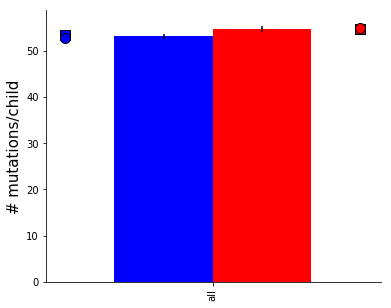

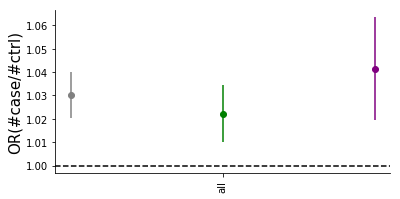

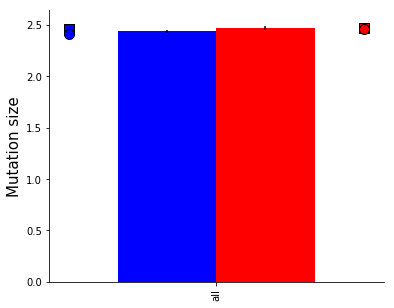

In [82]:
# Overall burden, adjust for father age
PlotBurden(finaldata, [finaldata], ["all"], col=None, freq=1, figprefix="Figure3-All", adjust_patage=True)

### Overall burden, adjust for father age, no homopolymers
finaldata_nohom = finaldata[finaldata["period_x"]>1]
PlotBurden(finaldata_nohom, [finaldata_nohom], ["all"], col=None, freq=1, figprefix="Figure3-All-NoHomopolymer", adjust_patage=True)

num total muts=171578
num total control muts=84515 male=40724 female=43791
num total case muts=87063 male=76307 female=10756
***Test burden - All
1593
Unaff mean=53.05398618957941
Aff mean=54.653483992467045
Mean diff=1.5994978028876332
MannwhitneyuResult(statistic=1175631.0, pvalue=0.00016464408277299932)
Ttest_relResult(statistic=-4.923116524684414, pvalue=9.40181167618077e-07)
Male burden: MannwhitneyuResult(statistic=504043.0, pvalue=0.02072742770336983)
Male burden: Ks_2sampResult(statistic=0.05607253638749702, pvalue=0.042806870966532774)
Female burden: MannwhitneyuResult(statistic=73902.5, pvalue=0.021795513061442066)
Female burden: Ks_2sampResult(statistic=0.08139934674230703, pvalue=0.11479468775706152)
***Odds ratios
all=1.0301484943501154
male=1.0220508790884981
female=1.0413839578442872
num proband all=1593
num proband male=1397
num proband female=196
num unaff all=1593
num unaff male=762
num unaff female=831
***Test mutation size
MannwhitneyuResult(statistic=3659432165.0, 

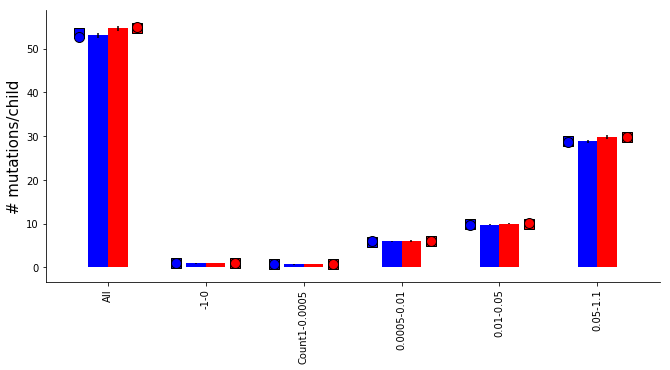

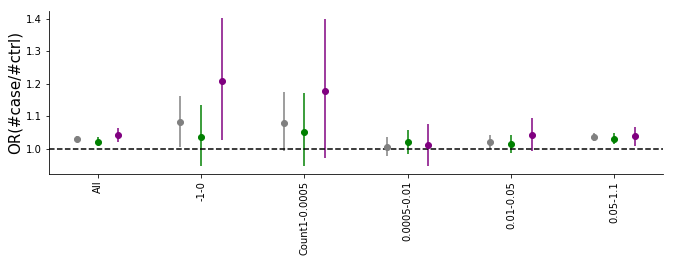

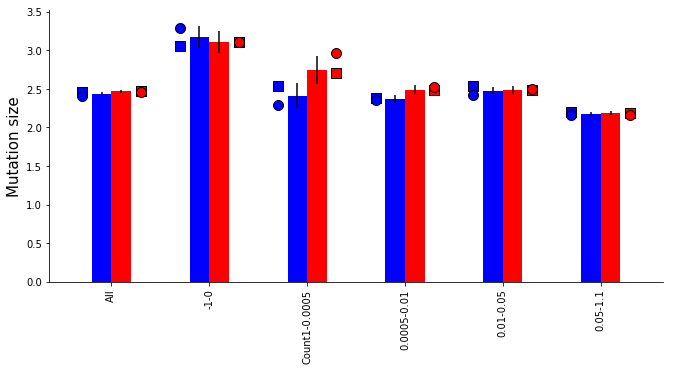

In [212]:
# By freq bin of target allele - overall
# (i.e. <0.001; 0.001-0.01; 0.01-0.05; >0.05)

mintotal = 0.8*max(fdata["total"])

# All
fdata_list = [finaldata]
fdata_labels_list = ["All"]

# Other freq bins
for freqpair in [(-1, 0), (-1,0.0005), (0.0005, 0.01), (0.01, 0.05), (0.05, 1.1)]:
    minfreq, maxfreq = freqpair
    if minfreq == -1 and maxfreq > 0:
        fdata_list.append(finaldata[(finaldata["total"]>=mintotal) & (finaldata["freq"]>0) & (finaldata["freq"]<=maxfreq)])
        fdata_labels_list.append("Count1-%s"%(maxfreq))
    else:
        fdata_list.append(finaldata[(finaldata["total"]>=mintotal) & (finaldata["freq"]>minfreq) & (finaldata["freq"]<=maxfreq)])
        fdata_labels_list.append("%s-%s"%(minfreq,maxfreq))
PlotBurden(finaldata, fdata_list, fdata_labels_list, col=None, freq=1, figprefix="Figure3-ByFreqBin", adjust_patage=False) 

In [213]:
# Is the OR significantly higher for mutations to "novel" alleles vs. "all"?

table_all = [[1542, 87063-1642],
            [1427, 84515-1526]]
print(scipy.stats.fisher_exact(table_all, alternative="greater"))


# Female significant
table_female = [[206, 10756-212],
            [723, 43791-774]]
print(scipy.stats.fisher_exact(table_female, alternative="greater"))

table_male = [[1336, 76307-1430],
            [704, 40724-752]]
print(scipy.stats.fisher_exact(table_male, alternative="greater"))

(1.0498234774633315, 0.0978557342275829)
(1.1624215301695642, 0.03364859557528735)
(1.0130741689097393, 0.4009557473267617)


num total muts=71822
num total control muts=35409 male=16880 female=18529
num total case muts=36413 male=31894 female=4519
***Test burden - All
1593
Unaff mean=22.227871939736346
Aff mean=22.858129315756436
Mean diff=0.63025737602009
MannwhitneyuResult(statistic=1196716.0, pvalue=0.002705637805446356)
Ttest_relResult(statistic=-3.509661644363018, pvalue=0.0004611708269079333)
Male burden: MannwhitneyuResult(statistic=498193.5, pvalue=0.006865275311493792)
Male burden: Ks_2sampResult(statistic=0.05308995466475781, pvalue=0.05917238409723044)
Female burden: MannwhitneyuResult(statistic=76768.5, pvalue=0.10534087996174946)
Female burden: Ks_2sampResult(statistic=0.08771089663302144, pvalue=0.08141347719762897)
***Odds ratios
all=1.0283543731819595
male=1.030611805256355
female=1.034035174866536
num proband all=1593
num proband male=1397
num proband female=196
num unaff all=1593
num unaff male=762
num unaff female=831
***Test mutation size
MannwhitneyuResult(statistic=642110293.0, pvalue=0

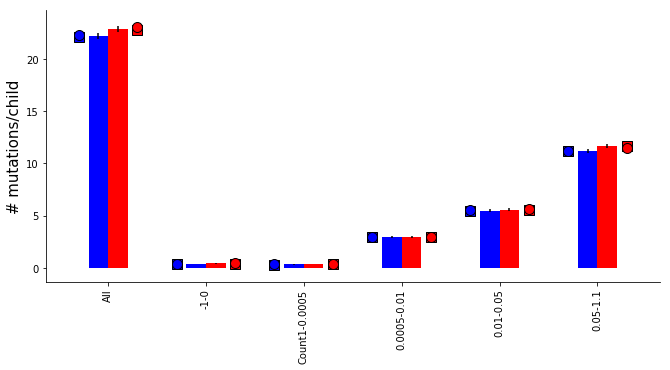

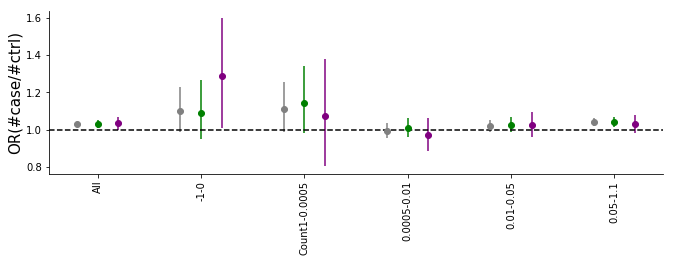

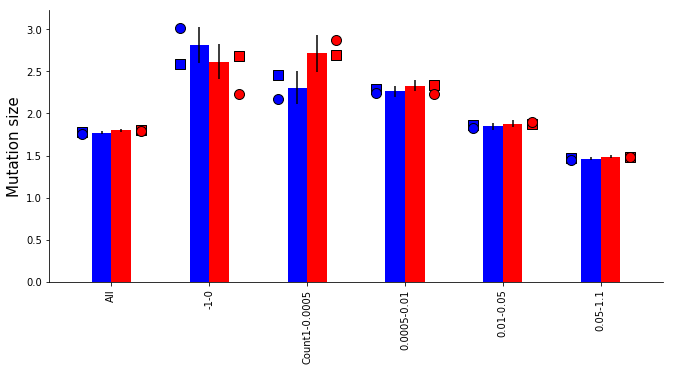

In [210]:
# By freq bin of target allele - overall
# (i.e. <0.001; 0.001-0.01; 0.01-0.05; >0.05)

mintotal = 0.8*max(fdata["total"])

# All
fdata_list = [finaldata[(finaldata["period_x"]>1)]]
fdata_labels_list = ["All"]

# Other freq bins
for freqpair in [(-1, 0), (-1,0.0005), (0.0005, 0.01), (0.01, 0.05), (0.05, 1.1)]:
    minfreq, maxfreq = freqpair
    if minfreq == -1 and maxfreq > 0:
        fdata_list.append(finaldata[(finaldata["period_x"]>1) & (finaldata["total"]>=mintotal) & (finaldata["freq"]>0) & (finaldata["freq"]<=maxfreq)])
        fdata_labels_list.append("Count1-%s"%(maxfreq))
    else:
        fdata_list.append(finaldata[(finaldata["period_x"]>1) & (finaldata["total"]>=mintotal) & (finaldata["freq"]>minfreq) & (finaldata["freq"]<=maxfreq)])
        fdata_labels_list.append("%s-%s"%(minfreq,maxfreq))
PlotBurden(finaldata[(finaldata["period_x"]>1)], fdata_list, fdata_labels_list, col=None, freq=1, figprefix="Figure3-ByFreqBin-NoHomopolymer", adjust_patage=False) 

num total muts=6285
num total control muts=3073 male=1455 female=1618
num total case muts=3212 male=2831 female=381
***Test burden - All sel
1556
Unaff mean=1.974935732647815
Aff mean=2.06426735218509
Mean diff=0.08933161953727509
MannwhitneyuResult(statistic=1168664.0, pvalue=0.04315654113669525)
Ttest_relResult(statistic=-1.7564556798860207, pvalue=0.0792074544554696)
Male burden: MannwhitneyuResult(statistic=367913.5, pvalue=0.06626342141034829)
Male burden: Ks_2sampResult(statistic=0.043075707990725645, pvalue=0.20435207780178036)
Female burden: MannwhitneyuResult(statistic=56624.5, pvalue=0.2982223288272384)
Female burden: Ks_2sampResult(statistic=0.05623865288808198, pvalue=0.41382532113347104)
***Odds ratios
all=1.0452326716563618
male=1.0419353079146896
female=1.0300264660605003
num proband all=1556
num proband male=1197
num proband female=163
num unaff all=1556
num unaff male=641
num unaff female=713
***Test mutation size
MannwhitneyuResult(statistic=4980052.5, pvalue=0.795226

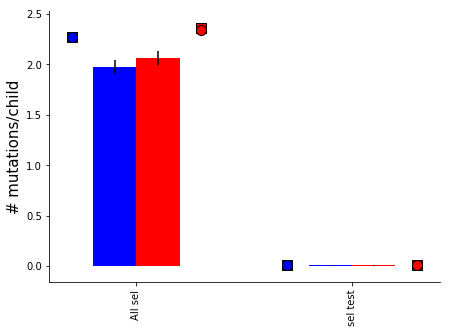

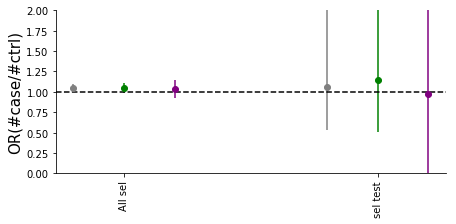

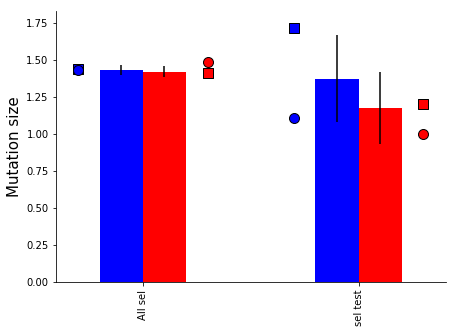

In [226]:
# Try to add Bonnie's scores
selscores = pd.read_csv("/storage/BonnieH/selection_project/per_locus/results/per_locus_results_prelim.txt", sep="\t")
selscores = selscores[~selscores["chrom"].isin(["chrX","chrY"])]
selscores["chrom"] = selscores["chrom"].apply(lambda x: int(x[3:]))
selscores["pos"] = selscores["start"]
seldata = pd.merge(finaldata, selscores, on=["chrom","pos"])

fdata_list = [seldata]
fdata_labels_list = ["All sel"]
fdata_list.append(seldata[seldata["ABC_s_median"]>0.01])
fdata_labels_list.append("sel test")
PlotBurden(seldata, fdata_list, fdata_labels_list, col=None, freq=1, maxORy=2, figprefix="del-selection", adjust_patage=False) 


# Figure 3C,D, Supp Fig. 10 Mutation burden by category

num total muts=220
num total control muts=109 male=56 female=53
num total case muts=111 male=97 female=14
***Test burden - UTR5
1593
Unaff mean=0.06842435655994979
Aff mean=0.0696798493408663
Mean diff=0.001255492780916509
MannwhitneyuResult(statistic=1267234.5, pvalue=0.44385149537448526)
Ttest_relResult(statistic=-0.1373182566010923, pvalue=0.8907966044208092)
Male burden: MannwhitneyuResult(statistic=533822.0, pvalue=0.6016346444695352)
Male burden: Ks_2sampResult(statistic=0.0, pvalue=1.0)
Female burden: MannwhitneyuResult(statistic=81113.0, pvalue=0.41840458782937695)
Female burden: Ks_2sampResult(statistic=0.0038986713819101648, pvalue=0.9921977739469175)
***Odds ratios
all=1.018348623853211
male=0.9448051948051948
female=1.1199460916442048
num proband all=1593
num proband male=1397
num proband female=196
num unaff all=1593
num unaff male=762
num unaff female=831
***Test mutation size
MannwhitneyuResult(statistic=6213.5, pvalue=0.6531485293637433)
1.798165137614679
1.828828828828

Male burden: Ks_2sampResult(statistic=0.03602958721068957, pvalue=0.26911746698384476)
Female burden: MannwhitneyuResult(statistic=82329.5, pvalue=0.5960162506486639)
Female burden: Ks_2sampResult(statistic=0.0169392666814018, pvalue=0.9008648873589848)
***Odds ratios
all=1.0134703196347032
male=1.018774230082328
female=1.0003181822227365
num proband all=1593
num proband male=1397
num proband female=196
num unaff all=1593
num unaff male=762
num unaff female=831
***Test mutation size
MannwhitneyuResult(statistic=9527030.0, pvalue=0.03619921332305092)
2.307077625570776
2.3780130660058574
1.0
1.0
OR - all: [1.04918981 1.01347032]
OR - male: [1.02712545 1.01877423]
OR - female: [1.0355373  1.00031818]
OR low - all: [1.01519542 0.97203539]
OR low - male: [0.98550514 0.9664261 ]
OR low - female: [0.95940579 0.908253  ]
OR high - all: [1.08435079 1.05668382]
OR high - male: [1.07107196 1.07487744]
OR high - female: [1.11393153 1.09573622]


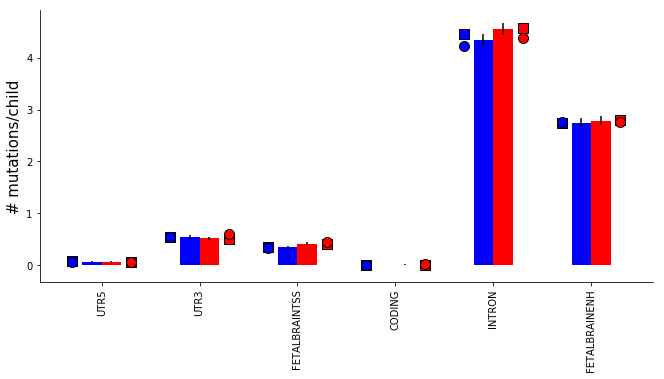

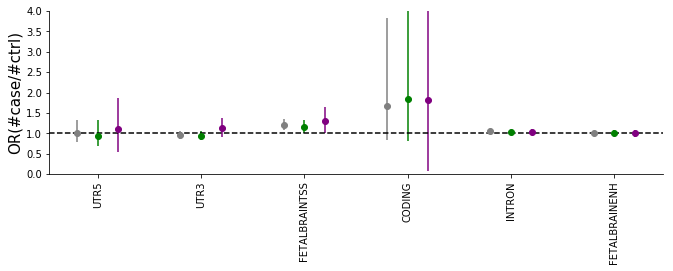

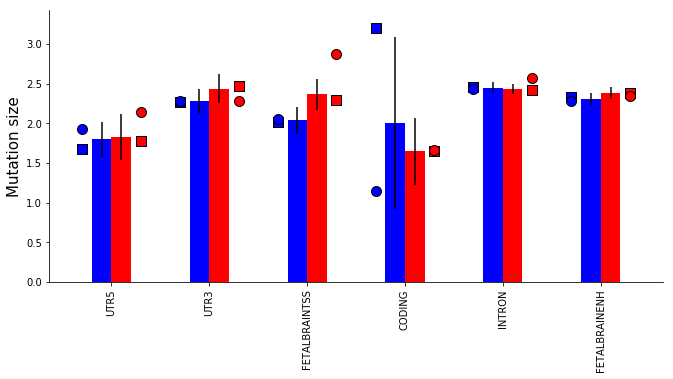

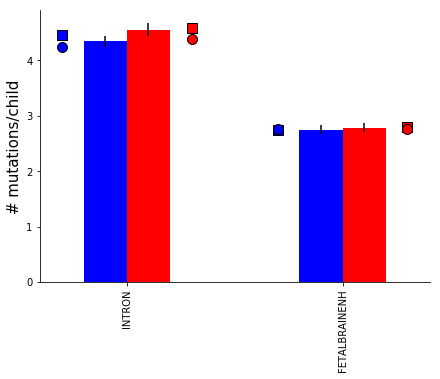

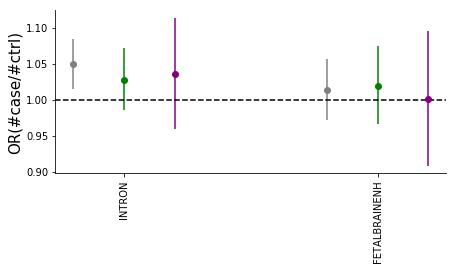

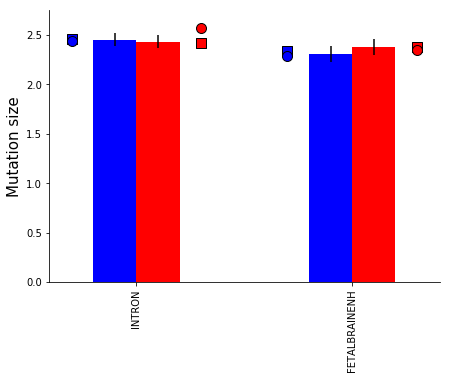

In [230]:
mintotal = 0
# By category
fdata_list = []
fdata_labels_list = []
for col in ['FEATURE-UTR5','FEATURE-UTR3', 'FEATURE-FETALBRAINTSS', 'FEATURE-CODING', 'FEATURE-INTRON', 'FEATURE-FETALBRAINENH']:
    fdata_list.append(finaldata[(finaldata[col]>0) & (finaldata["total"]>=mintotal)])
    fdata_labels_list.append(col.split("-")[1])
PlotBurden(finaldata, fdata_list, fdata_labels_list, col=None, freq=1, maxORy=4, figprefix="Figure3-ByFeature1-all", adjust_patage=False) 

fdata_list = []
fdata_labels_list = []
for col in ['FEATURE-INTRON', 'FEATURE-FETALBRAINENH']:
    fdata_list.append(finaldata[(finaldata[col]>0) & (finaldata["total"]>=mintotal) ])
    fdata_labels_list.append(col.split("-")[1])
PlotBurden(finaldata, fdata_list, fdata_labels_list, col=None, freq=1, figprefix="Figure3-ByFeature2-all", adjust_patage=False) 

num total muts=184
num total control muts=91 male=46 female=45
num total case muts=93 male=83 female=10
***Test burden - UTR5
1593
Unaff mean=0.05712492153170119
Aff mean=0.0583804143126177
Mean diff=0.001255492780916509
MannwhitneyuResult(statistic=1265731.5, pvalue=0.3834866421130232)
Ttest_relResult(statistic=-0.1507094217827765, pvalue=0.8802240332005451)
Male burden: MannwhitneyuResult(statistic=532108.0, pvalue=0.48953834180682687)
Male burden: Ks_2sampResult(statistic=0.00035790980672870435, pvalue=0.9995509591307947)
Female burden: MannwhitneyuResult(statistic=81600.0, pvalue=0.5447979310655892)
Female burden: Ks_2sampResult(statistic=0.0, pvalue=1.0)
***Odds ratios
all=1.021978021978022
male=0.9841897233201582
female=0.9421768707482994
num proband all=1593
num proband male=1397
num proband female=196
num unaff all=1593
num unaff male=762
num unaff female=831
***Test mutation size
MannwhitneyuResult(statistic=4392.5, pvalue=0.6917337057857468)
1.835164835164835
1.84946236559139

Male burden: Ks_2sampResult(statistic=0.03746122643760439, pvalue=0.24228263191505856)
Female burden: MannwhitneyuResult(statistic=82951.0, pvalue=0.6616901735547511)
Female burden: Ks_2sampResult(statistic=0.017037500920945997, pvalue=0.8998795500232526)
***Odds ratios
all=0.998921639108555
male=1.0126301179736295
female=0.9994627606477373
num proband all=1593
num proband male=1397
num proband female=196
num unaff all=1593
num unaff male=762
num unaff female=831
***Test mutation size
MannwhitneyuResult(statistic=3831398.5, pvalue=0.25407363053754006)
1.792235801581596
1.820798848506657
1.0
1.0
OR - all: [1.05377907 0.99892164]
OR - male: [1.04848032 1.01263012]
OR - female: [0.98878633 0.99946276]
OR low - all: [1.00024708 0.94775583]
OR low - male: [0.98207178 0.94745471]
OR low - female: [0.87293786 0.88511263]
OR high - all: [1.11025518 1.05284813]
OR high - male: [1.12092546 1.08375598]
OR high - female: [1.11000649 1.11903225]


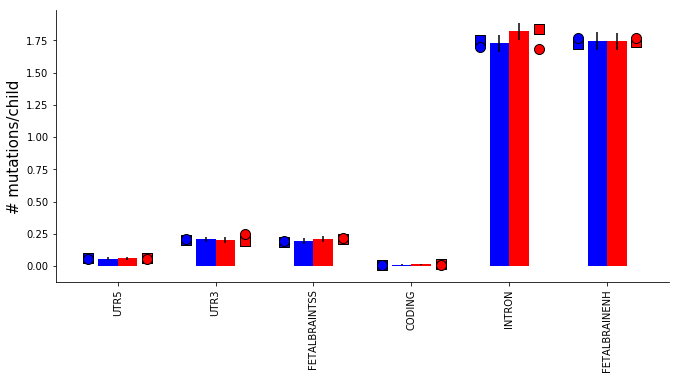

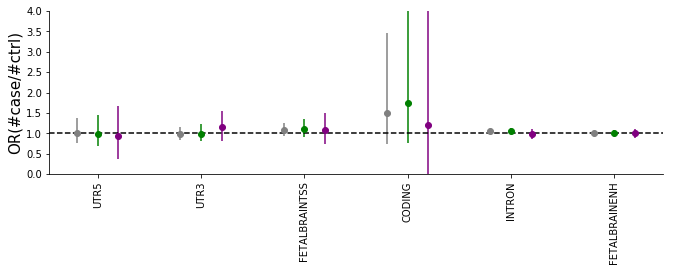

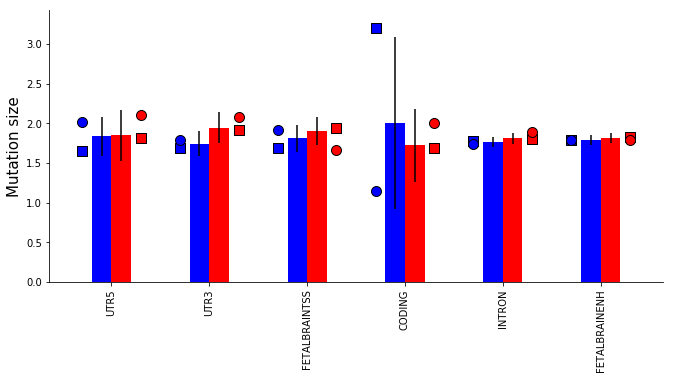

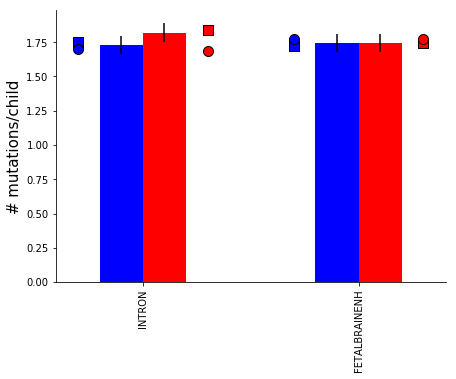

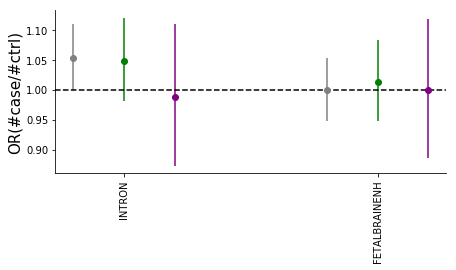

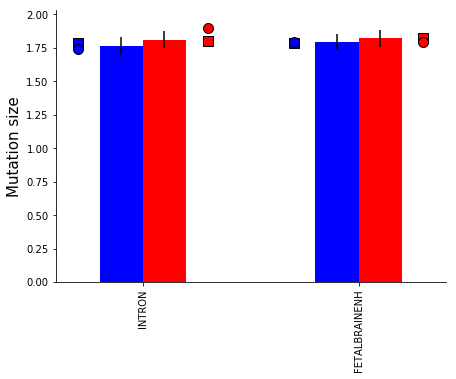

In [229]:
mintotal = 0

# By category - nohomopolymer
fdata_list = []
fdata_labels_list = []
for col in ['FEATURE-UTR5','FEATURE-UTR3', 'FEATURE-FETALBRAINTSS', 'FEATURE-CODING', 'FEATURE-INTRON', 'FEATURE-FETALBRAINENH']:
    fdata_list.append(finaldata[(finaldata[col]>0) & (finaldata["period_x"]>1) & (finaldata["total"]>=mintotal) ])
    fdata_labels_list.append(col.split("-")[1])
PlotBurden(finaldata, fdata_list, fdata_labels_list, maxORy=4, col=None, freq=1, figprefix="Figure3-ByFeature1-all-nohomopolymer", adjust_patage=False) 

fdata_list = []
fdata_labels_list = []
for col in ['FEATURE-INTRON', 'FEATURE-FETALBRAINENH']:
    fdata_list.append(finaldata[(finaldata[col]>0) & (finaldata["period_x"]>1) & (finaldata["total"]>=mintotal) ])
    fdata_labels_list.append(col.split("-")[1])
PlotBurden(finaldata, fdata_list, fdata_labels_list, col=None, freq=1, figprefix="Figure3-ByFeature2-all-nohomopolymer", adjust_patage=False) 

num total muts=81
num total control muts=40 male=14 female=26
num total case muts=41 male=35 female=6
***Test burden - UTR5
1593
Unaff mean=0.025109855618330193
Aff mean=0.02573760200878845
MannwhitneyuResult(statistic=1268028.0, pvalue=0.4552282522388372)
Ttest_relResult(statistic=-0.11247391792402892, pvalue=0.9104618286807098)
Male burden: MannwhitneyuResult(statistic=528701.0, pvalue=0.15969075818615303)
Female burden: MannwhitneyuResult(statistic=81493.0, pvalue=0.5196886181837169)
***Odds ratios
all=1.0250000000000001
male=1.3636363636363638
female=0.9784144427001569
num proband all=1593
num proband male=1397
num proband female=196
num unaff all=1593
num unaff male=762
num unaff female=831
***Test mutation size
MannwhitneyuResult(statistic=796.5, pvalue=0.40994637418611224)
2.125
2.3902439024390243
2.0
2.0
num total muts=272
num total control muts=127 male=50 female=77
num total case muts=145 male=128 female=17
***Test burden - UTR3
1593
Unaff mean=0.07972379158819837
Aff mean=0.

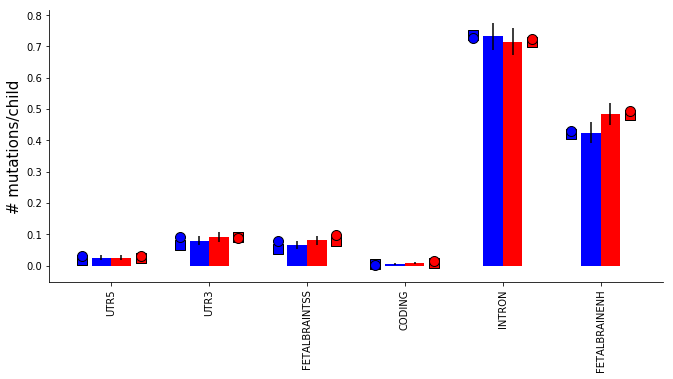

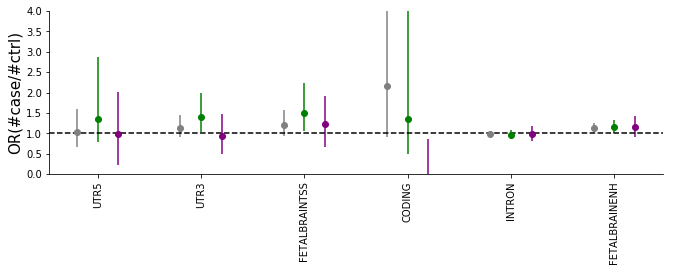

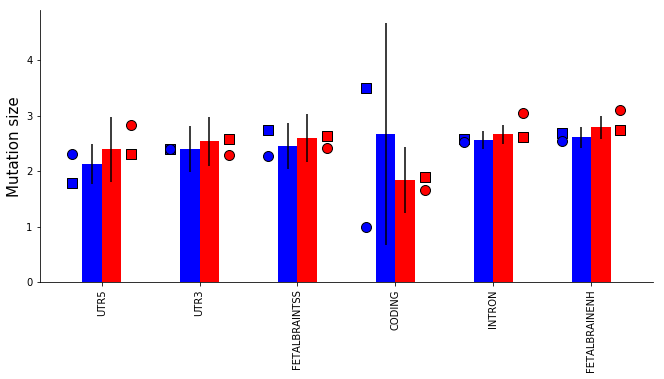

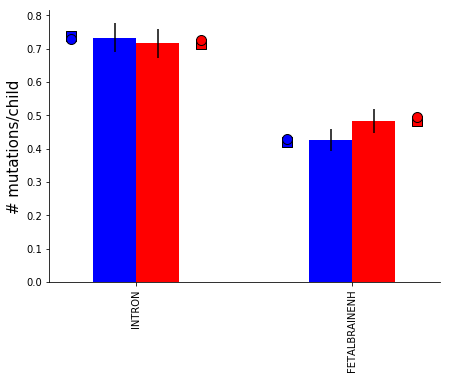

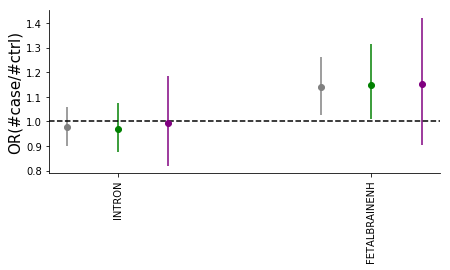

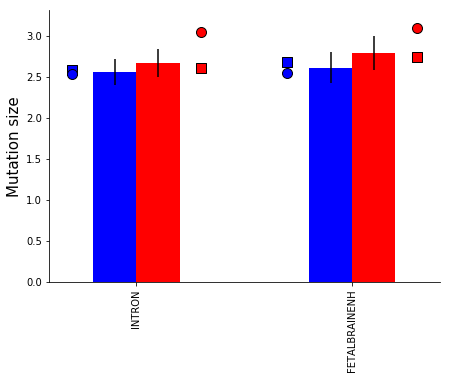

In [120]:
# By category - rare
fdata_list = []
fdata_labels_list = []
for col in ['FEATURE-UTR5','FEATURE-UTR3', 'FEATURE-FETALBRAINTSS', 'FEATURE-CODING', 'FEATURE-INTRON', 'FEATURE-FETALBRAINENH']:
    fdata_list.append(finaldata[(finaldata[col]>0) & (finaldata["freq"]<0.01)])
    fdata_labels_list.append(col.split("-")[1])
PlotBurden(finaldata, fdata_list, fdata_labels_list, maxORy=4, col=None, freq=1, figprefix="Figure3-ByFeature1-all-rare", adjust_patage=False) 

fdata_list = []
fdata_labels_list = []
for col in ['FEATURE-INTRON', 'FEATURE-FETALBRAINENH']:
    fdata_list.append(finaldata[(finaldata[col]>0) & (finaldata["freq"]<0.01)])
    fdata_labels_list.append(col.split("-")[1])
PlotBurden(finaldata, fdata_list, fdata_labels_list, col=None, freq=1, figprefix="Figure3-ByFeature2-all-rare", adjust_patage=False) 


# Supplementary Fig. 11

974004
648925


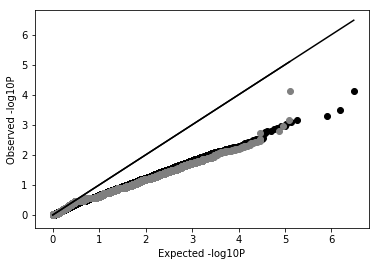

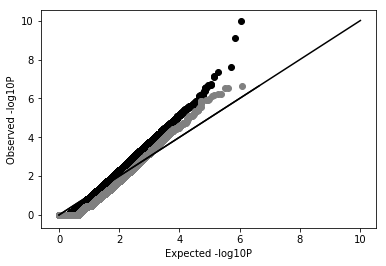

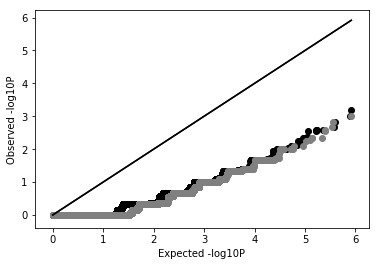

In [127]:
# Load per-locus mutation info. Annotate with period
data = pd.read_csv(LOCFILE, delim_whitespace=True)
data = pd.merge(data, annot[["chrom","pos","period"]], how="left", on=["chrom","pos"])

print(data.shape[0])
print(data[data["period"]>1].shape[0])

def QQPlot(pvals, ax, color="black"):
    y_pvals = -1*np.log10(sorted(pvals))
    x_pvals = -1*np.log10(sorted(list(np.random.uniform(size=len(pvals)))))
    ax.scatter(x_pvals, y_pvals, color=color)
    maxval = max(max(y_pvals), max(x_pvals))
    ax.plot([0,maxval],[0,maxval], color="black")
    
fig = plt.figure()
ax = fig.add_subplot(111)
QQPlot(list(data[~np.isnan(data["assoc_p"])]["assoc_p"]), ax, color="black")
QQPlot(list(data[(~np.isnan(data["assoc_p"])) & (data["period"]>1)]["assoc_p"]), ax, color="gray")
ax.set_xlabel("Expected -log10P")
ax.set_ylabel("Observed -log10P")
fig.savefig(os.path.join(OUTDIR, "SuppFig_QQPlot_assoc_P.png"))

fig = plt.figure()
ax = fig.add_subplot(111)
QQPlot(list(data[~np.isnan(data["tdt_p_combined"])]["tdt_p_combined"]), ax, color="black")
QQPlot(list(data[(~np.isnan(data["tdt_p_combined"])) & (data["period"]>1)]["tdt_p_combined"]), ax, color="gray")
ax.set_xlabel("Expected -log10P")
ax.set_ylabel("Observed -log10P")
fig.savefig(os.path.join(OUTDIR, "SuppFig_QQPlot_tdt_P.png"))

fig = plt.figure()
ax = fig.add_subplot(111)
QQPlot(list(data[~np.isnan(data["fisher_p"])]["fisher_p"]), ax, color="black")
QQPlot(list(data[(~np.isnan(data["fisher_p"])) & (data["period"]>1)]["fisher_p"]), ax, color="gray")
ax.set_xlabel("Expected -log10P")
ax.set_ylabel("Observed -log10P")
fig.savefig(os.path.join(OUTDIR, "SuppFig_QQPlot_burden_P.png"))

# Supplementary Fig. 12: Power

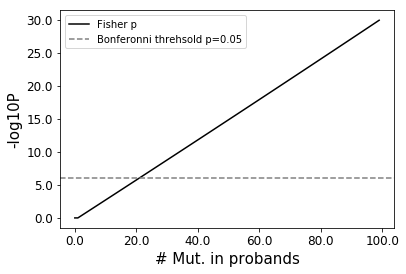

In [10]:
# Contingency tables will have: status(0/1) x mutation(0/1)
# First, for different numbers of families, see how many mutations
# we need to see in probands (with 0 in controls) for genome-wide significance

NUMLOCI = 60000 # 900000 # approximate num genome-wide loci analyzed per family.
# should we use total number, of only total num with any mutations?
NUMMUTS = range(100)
NVALS = [2500]
power_vals = {} # N -> vals

for N in NVALS:
    # For each N, test different numbers of muts in proband
    pvals = []
    for aff_mut in NUMMUTS:
        table = [[aff_mut, 0], [N-aff_mut, N]]
        p = scipy.stats.fisher_exact(table)[1]
        pvals.append(p)
    power_vals[N] = pvals

fig = plt.figure()
ax = fig.add_subplot(111)
N = 2500
ax.plot(NUMMUTS, [-1*np.log10(item) for item in power_vals[N]], label="Fisher p", color="black")
ax.axhline(y=-1*np.log10(0.05/NUMLOCI), color="gray", linestyle="dashed", label="Bonferonni threhsold p=0.05")
ax.set_xlabel("# Mut. in probands", size=15)
ax.set_ylabel("-log10P", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12);
ax.legend()
fig.savefig(os.path.join(OUTDIR, "SuppFigure_Power.pdf"))